<a href="https://colab.research.google.com/github/charlie9526/TaxiFare/blob/master/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) IMPORTS

In [0]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import random
from google.colab import files
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)              
import numpy as np                  
from scipy.stats import norm   
import warnings
warnings.filterwarnings('ignore')   
%matplotlib inline                 

from sklearn.base import BaseEstimator, TransformerMixin
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FAIR_TAXI/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FAIR_TAXI/test.csv')
sample_submission_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FAIR_TAXI/sample_submission.csv')

# 2) Functions

#3) PRE PROCESS

## 3.1) Check Nulls (not related for pipeline)


In [0]:
## DROP ALL NULL FARE ROWS
train_df = train_df.dropna(subset=['fare'])

In [0]:
train_df.isnull().sum()

tripid                        0
additional_fare              71
duration                     71
meter_waiting                71
meter_waiting_fare           71
meter_waiting_till_pickup    71
pickup_time                   0
drop_time                     0
pick_lat                      0
pick_lon                      0
drop_lat                      0
drop_lon                      0
fare                          0
label                         0
dtype: int64

In [0]:
# train_df[train_df.isnull().any(axis=1)].to_csv("/content/drive/My Drive/Colab Notebooks/FAIR_TAXI/nulls.csv", index=True)

## 3.2) Check duration_value_by_me and duration 


In [0]:
########### This is a very specific function
########### Find the difference of durations
def get_duration_gap(x):
  if x['duration']=="NaN"or x['duration_by_me']=="NaN":
    return x['duration_by_me']
  return abs(x['duration']-x['duration_by_me'])

########### This function is a transformer
########### Converts all null values of duration using drop time and pick time

def get_duration(x):
  if x['pickup_time']==None or x['drop_time']==None:
    return None
  
  try :
    if int(x['pickup_time'].split("/")[1])>12 or int(x['drop_time'].split("/")[1])>12:
      gap = datetime.strptime(x['pickup_time'],"%m/%d/%Y %H:%M")-datetime.strptime(x['drop_time'],"%m/%d/%Y %H:%M")
    else:
      if int(x['pickup_time'].split("/")[1]) != int(x['drop_time'].split("/")[1]):
        gap = datetime.strptime(x['pickup_time'],"%m/%d/%Y %H:%M")-datetime.strptime(x['drop_time'],"%m/%d/%Y %H:%M")
      else:
        gap = datetime.strptime(x['pickup_time'],"%d/%m/%Y %H:%M")-datetime.strptime(x['drop_time'],"%d/%m/%Y %H:%M")
  except :
    return None
  return abs(gap.total_seconds())

class MakeTripDurationFeature(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['duration_by_me'] = X.apply(lambda x:get_duration(x), axis=1)
        return X

In [0]:
## FILL NULL VALUSE OF DURATION 
add_duration_by_me = MakeTripDurationFeature()
train_df = add_duration_by_me.transform(train_df)

train_df['duration_gap'] = train_df.apply(lambda x:get_duration_gap(x), axis=1)

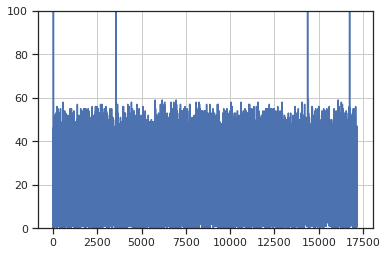

In [0]:
plt.plot(train_df['duration_gap'])
plt.ylim(0,100)
plt.grid(True)
plt.show()

In [0]:
# lets check difference values more than 50
train_df[abs(train_df['duration_gap'])>60].head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap
22,189157559,10.5,693.0,280.0,9.8838,318.0,11/1/2019 8:41,11/1/2019 8:51,6.91718,79.8656,6.90640,79.8793,109.36,correct,600.0,93.0
27,189163162,10.5,618.0,128.0,7.3984,126.0,11/1/2019 9:12,11/1/2019 9:20,6.88661,79.9321,6.87383,79.9263,106.80,correct,480.0,138.0
3549,193653017,0.0,0.0,0.0,0.0000,540.0,11/21/2019 15:57,11/21/2019 16:23,6.90471,79.8520,6.90457,79.8519,0.00,incorrect,1560.0,1560.0
14372,210523029,10.5,693.0,78.0,0.0000,37.0,1/17/2020 20:43,1/17/2020 20:52,6.84484,79.9342,6.83917,79.9087,140.55,correct,540.0,153.0
16742,213112837,0.0,0.0,0.0,0.0000,973.0,1/29/2020 20:00,1/29/2020 20:23,6.85275,79.9391,6.84612,79.9428,0.00,incorrect,1380.0,1380.0


In [0]:
# 
train_df[train_df['duration'].isnull()].head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,duration_by_me,duration_gap
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct,1020.0,NaN
91,189231599,NaN,NaN,NaN,NaN,NaN,11/1/2019 14:48,11/1/2019 15:03,7.04783,79.8973,7.05307,79.9188,196.50,incorrect,900.0,NaN
253,189393356,NaN,NaN,NaN,NaN,NaN,11/2/2019 13:29,11/2/2019 13:55,7.21158,79.8401,7.20136,79.8455,188.71,incorrect,1560.0,NaN
4305,194787966,NaN,NaN,NaN,NaN,NaN,11/25/2019 14:33,11/25/2019 16:27,7.32516,80.6318,7.29512,80.6373,828.64,correct,6840.0,NaN
4313,194804469,NaN,NaN,NaN,NaN,NaN,11/25/2019 15:06,11/25/2019 15:51,6.06285,80.2310,6.03445,80.2183,343.31,correct,2700.0,NaN


## 3.3) Check fare with the day's time period

In [0]:
################### Here we have to add two columns
################### The hour value and fare per hour value
################### Lets write a lambda function 

def get_hour_value(x,date_time_column_name):
  if x[date_time_column_name]==None:
    return None
  return datetime.strptime(x[date_time_column_name],"%m/%d/%Y %H:%M").hour

################### Here we have to add fare_per_hour column
################### write a lambda function

def get_fare_per_min(x):
  if x["fare"]>=0 and x["duration"]>0:
    minutes = x["duration"]/60.0
    val = x['fare']/minutes
    return val
  if x["duration"]==0:
    return 0
  return None


In [0]:

train_df['pickup_hour'] = train_df.apply(lambda x:get_hour_value(x,"pickup_time"),axis=1)
train_df['drop_hour'] = train_df.apply(lambda x:get_hour_value(x,"drop_time"),axis=1)
train_df['fare_per_min'] = train_df.apply(lambda x:get_fare_per_min(x),axis=1 )

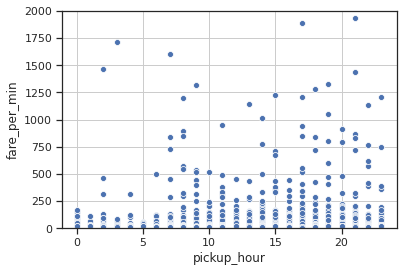

In [0]:
graph = sns.scatterplot(x="pickup_hour",y="fare_per_min",data=train_df)
graph.set_ylim(0,2000)
graph.grid(True)

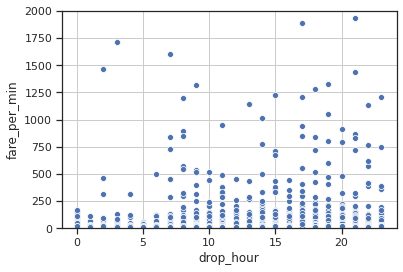

In [0]:
graph = sns.scatterplot(x="drop_hour",y="fare_per_min",data=train_df)
graph.set_ylim(0,2000)
graph.grid(True)

In [0]:
train_df.isna().sum()

tripid                        0
additional_fare              71
duration                     71
meter_waiting                71
meter_waiting_fare           71
meter_waiting_till_pickup    71
pickup_time                   0
drop_time                     0
pick_lat                      0
pick_lon                      0
drop_lat                      0
drop_lon                      0
fare                          0
label                         0
duration_by_me                0
duration_gap                 71
pickup_hour                   0
drop_hour                     0
fare_per_min                 71
dtype: int64

**Decesion**


---
Here the duration gap of null duration values are not considered. They are irrelevant here.\
Only two observations form the whole datasset are passed the duration gap around 100.\
those id s are \
     1) 213112837	\
     2) 193653017	


# 4) Dcesions

**1) Evaluate default "duration" and real duration.**


---
Here the duration gap of null duration values are not considered. They are irrelevant here.\
Only two observations form the whole datasset are passed the duration gap around 100.\
those id s are \
     1) 213112837	\
     2) 193653017	


**2) Remove Null fare values as whole row**

---
No point of fare null values because the fare should be the most important


**3) Fill Null duration values with real duration**

**4) Its better to use pickup hour and drop hour**

---
There is a small releationship can be seen in 3.3 section 


second
